In [153]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense,Activation,Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,BatchNormalization


In [154]:
import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import DenseNet121

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

In [155]:
train = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/train.csv")
test = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv")
images = "/kaggle/input/plant-pathology-2020-fgvc7/images/"
sub = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv")
dir_path2 = '/kaggle/working/images'

In [156]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [157]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [158]:

def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(images + file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train["image_id"][:100].progress_apply(load_image)

100%|██████████| 100/100 [00:02<00:00, 39.18it/s]


In [ ]:
fig = px.imshow(cv2.resize(train_images[0], (205, 136)))
fig.show()

In [160]:
red_values = [np.mean(train_images[idx][:, :, 0]) for idx in range(len(train_images))]
green_values = [np.mean(train_images[idx][:, :, 1]) for idx in range(len(train_images))]
blue_values = [np.mean(train_images[idx][:, :, 2]) for idx in range(len(train_images))]
values = [np.mean(train_images[idx]) for idx in range(len(train_images))]

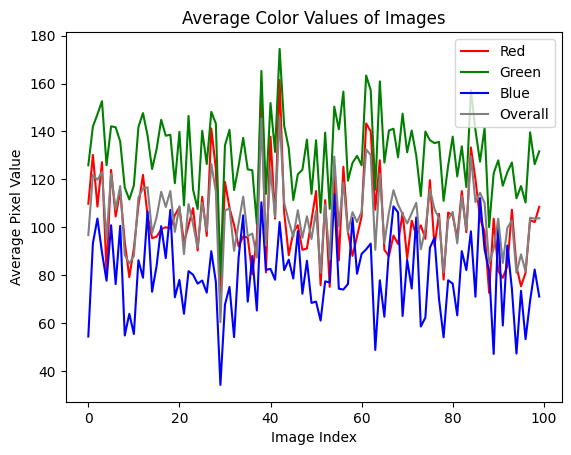

In [161]:
import matplotlib.pyplot as plt

indices = list(range(len(red_values)))  

fig, ax = plt.subplots()

ax.plot(indices, red_values, label='Red', color='red')
ax.plot(indices, green_values, label='Green', color='green')
ax.plot(indices, blue_values, label='Blue', color='blue')
ax.plot(indices, values, label='Overall', color='gray')  # Overall average might overlap, so it's gray

ax.set_title('Average Color Values of Images')
ax.set_xlabel('Image Index')
ax.set_ylabel('Average Pixel Value')

ax.legend()

plt.show()


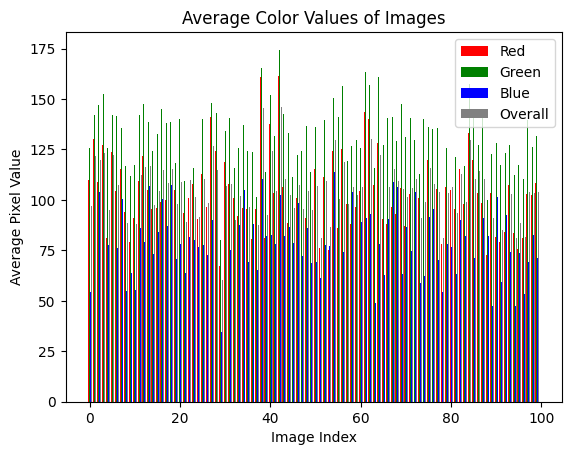

In [162]:
fig, ax = plt.subplots()

bar_width = 0.2
ax.bar([x - bar_width for x in indices], red_values, width=bar_width, color='red', label='Red')
ax.bar(indices, green_values, width=bar_width, color='green', label='Green')
ax.bar([x + bar_width for x in indices], blue_values, width=bar_width, color='blue', label='Blue')
ax.bar([x + 2*bar_width for x in indices], values, width=bar_width, color='gray', label='Overall')

ax.set_title('Average Color Values of Images')
ax.set_xlabel('Image Index')
ax.set_ylabel('Average Pixel Value')
ax.legend()

plt.show()


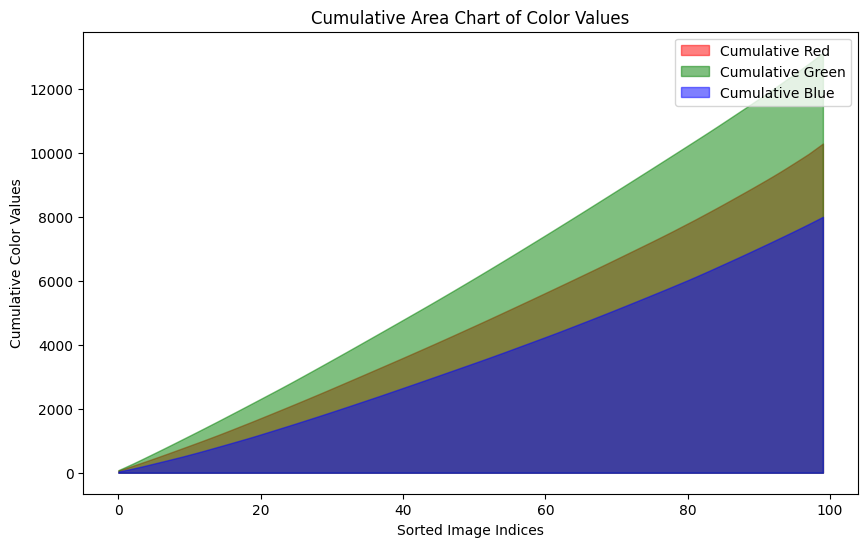

In [163]:
import numpy as np

# Data preparation
indices = np.arange(len(red_values))
cumulative_red = np.cumsum(sorted(red_values))
cumulative_green = np.cumsum(sorted(green_values))
cumulative_blue = np.cumsum(sorted(blue_values))

# Plotting the area chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(indices, 0, cumulative_red, color='red', alpha=0.5, label='Cumulative Red')
ax.fill_between(indices, 0, cumulative_green, color='green', alpha=0.5, label='Cumulative Green')
ax.fill_between(indices, 0, cumulative_blue, color='blue', alpha=0.5, label='Cumulative Blue')

ax.set_title('Cumulative Area Chart of Color Values')
ax.set_xlabel('Sorted Image Indices')
ax.set_ylabel('Cumulative Color Values')
ax.legend()

plt.show()


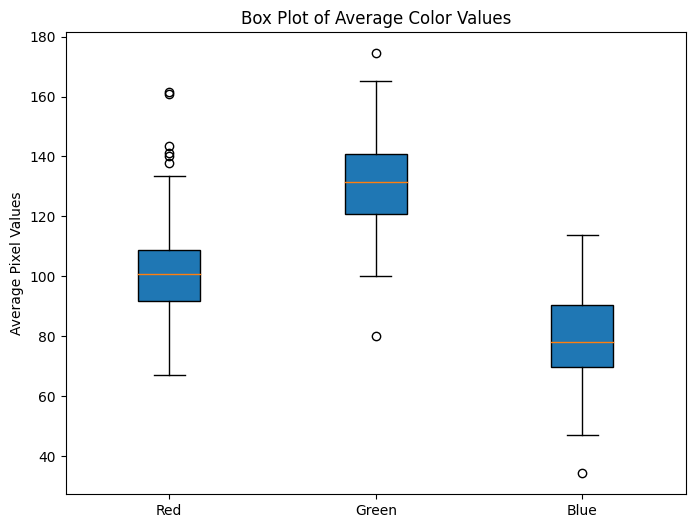

In [164]:
# Setting up the box plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting all color values in one box plot for comparison
color_data = [red_values, green_values, blue_values]
ax.boxplot(color_data, patch_artist=True, labels=['Red', 'Green', 'Blue'])

ax.set_title('Box Plot of Average Color Values')
ax.set_ylabel('Average Pixel Values')

plt.show()


In [165]:
data=train.copy()

In [166]:
data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [167]:
conditions = [
    (data['healthy'] == 1),
    (data['multiple_diseases'] == 1),
    (data['rust'] == 1),
    (data['scab'] == 1)
]
choices = ['healthy', 'multiple_diseases', 'rust', 'scab']
data['class'] = pd.Series(np.select(conditions, choices, default='unknown'))
data.drop(['healthy', 'multiple_diseases', 'rust', 'scab'], axis=1, inplace=True)


data['class'].value_counts()

class
rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: count, dtype: int64

In [168]:
data.head()

,image_id,class
0,Train_0,scab
1,Train_1,multiple_diseases
2,Train_2,healthy
3,Train_3,rust
4,Train_4,healthy


In [ ]:
import pandas as pd
import plotly.express as px

class_counts = data['class'].value_counts()
fig = px.bar(class_counts, x=class_counts.index, y=class_counts.values, title="Distribution of Classes")
fig.show()


In [ ]:
fig = px.pie(data, names='class', title='Proportion of Each Class in Dataset', hole=0.4)
fig.show()

In [ ]:
fig = px.treemap(data, path=['class'], title='Treemap of Plant Classes')
fig.show()

In [172]:
data['health_status'] = data['class'].apply(lambda x: 'healthy' if x == 'healthy' else 'unhealthy')



In [ ]:
fig = px.pie(data, names='health_status', title='Proportion of Healthy vs. Unhealthy Plants', hole=0.4)
fig.show()

In [174]:
train['label'] = train[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)

# Map the labels to numeric values
label_mapping = {'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}
train['label'] = train['label'].map(label_mapping)

In [175]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


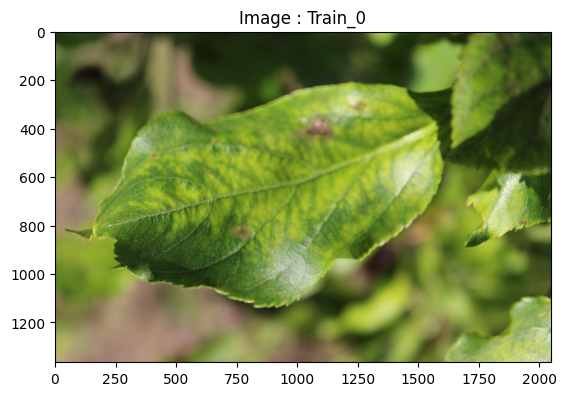

In [176]:
from PIL import Image
image_open = Image.open(images + 'Train_0.jpg')
plt.imshow(image_open)
plt.title('Image : Train_0')
plt.show()

In [177]:
import cv2
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math

def afficher_par_classe(classe, num_images=9):
    i = 0
    count = 0
    
    grid_size = math.ceil(math.sqrt(num_images))
    
    fig = make_subplots(rows=grid_size, cols=grid_size, horizontal_spacing=0.02, vertical_spacing=0.02)

    while i < len(data) and count < num_images:
        if data['class'].iloc[i] == classe:
            resized_image = cv2.resize(train_images[i], (205, 136))
            
            row = (count // grid_size) + 1
            col = (count % grid_size) + 1
            
            fig.add_trace(
                go.Image(z=resized_image),
                row=row, col=col
            )
            
            fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False, row=row, col=col)
            fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False, row=row, col=col)
            count += 1
        i += 1

    
    fig.update_layout(title_text=f"Images for class: {classe}", showlegend=False, margin=dict(l=0, r=0, t=20, b=0))
    fig.show()



In [ ]:
afficher_par_classe('healthy')
afficher_par_classe('multiple_diseases',6)
afficher_par_classe('rust')
afficher_par_classe('scab')

In [179]:
import re
def get_label(img):
    if re.search('Train',img):
        img = img.split('.')[0] # Fecth image_id from image name
        # return label corresponding to image_id
        label = train.loc[train['image_id'] == img, 'label'].values[0]
        return label
    elif re.search('Test',img):
        pass

In [180]:
from sklearn.model_selection import train_test_split

def copy_image_to_its_folder(images, dir_path2):
    image = natsort.natsorted([img for img in os.listdir(images) if img.startswith('Train_')])  # Filter images
    
    # Split the images into train and test sets
    train_images, test_images = train_test_split(image, test_size=0.3, random_state=42)
    
    # Create train and test directories if they don't exist
    train_dir = os.path.join(dir_path2, 'train')
    test_dir = os.path.join(dir_path2, 'test')
    for directory in [train_dir, test_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)
    
    # Copy images to train or test directories
    for img in tqdm(train_images):
        copy_image(img, images, train_dir)
    
    for img in tqdm(test_images):
        copy_image(img, images, test_dir)

def copy_image(img, src_dir, dest_dir):
    label = get_label(img)  # Getting label of the image
    src_path = os.path.join(src_dir, img)  # Original path of the image
    dest_label_dir = os.path.join(dest_dir, get_label_folder(label))
    
    if not os.path.exists(dest_label_dir):
        os.makedirs(dest_label_dir)
    
    shutil.copy(src_path, dest_label_dir)

def get_label_folder(label):
    label_mapping = {0: 'healthy', 1: 'multiple_diseases', 2: 'rust', 3: 'scab'}
    return label_mapping[label.item()]

In [181]:
pip install natsort

Note: you may need to restart the kernel to use updated packages.


In [182]:
import natsort
import shutil

data_dir = copy_image_to_its_folder(images, dir_path2)


100%|██████████| 547/547 [00:01<00:00, 287.18it/s]


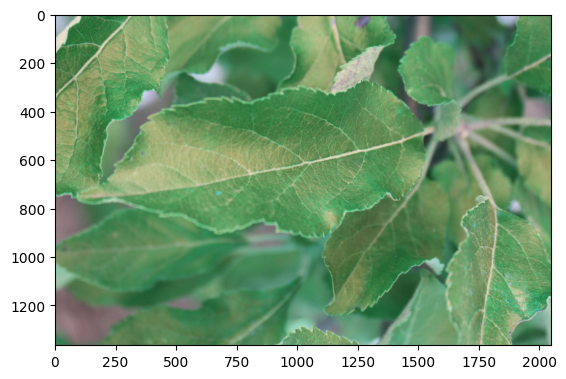

In [183]:
Train_dir = dir_path2 + '/train/'
Categories = ['healthy','multiple_diseases','rust','scab']
for i in Categories:
    path = os.path.join(Train_dir,i)
    for img in os.listdir(path):
        old_image = cv2.imread(os.path.join(path,img),cv2.COLOR_BGR2RGB)
        new_image=cv2.resize(old_image,(256,256))
        plt.imshow(old_image)
        plt.show()
        break
    break

In [184]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [185]:
datagen = ImageDataGenerator(validation_split=0.2)

train_datagen = datagen.flow_from_directory(
    Train_dir,
    target_size=(256, 256),  # Taille des images (identique à celle utilisée par votre modèle)
    batch_size=16,          # Taille des lots
    class_mode='categorical',  # Classification multi-classes
    subset='training'       # Indique que ce sont les données d'entraînement
)

val_datagen = datagen.flow_from_directory(
    Train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    subset='validation'     # Indique que ce sont les données de validation
)

Found 1021 images belonging to 4 classes.
Found 253 images belonging to 4 classes.


In [186]:
import numpy as np
from collections import Counter

class_counts = Counter(train_datagen.classes)
print("Répartition des classes dans les données d'entraînement :", class_counts)

Répartition des classes dans les données d'entraînement : Counter({2: 350, 3: 326, 0: 295, 1: 50})


In [187]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense,Activation,Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,BatchNormalization

In [188]:
model=Sequential()
model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(256,256,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(4,activation='softmax'))

In [189]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [190]:
checkpoint=ModelCheckpoint('apple_tree_diseases.keras',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=1)

earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0.001,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [191]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_datagen.classes),
    y=train_datagen.classes
)


In [192]:
class_weights = dict(enumerate(class_weights))

model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=10,
    class_weight=class_weights,  
    callbacks=callbacks
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2599 - loss: 7.9428
Epoch 1: val_loss improved from inf to 1.41523, saving model to apple_tree_diseases.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.2598 - loss: 7.8715 - val_accuracy: 0.0791 - val_loss: 1.4152
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1541 - loss: 1.4215
Epoch 2: val_loss improved from 1.41523 to 1.35552, saving model to apple_tree_diseases.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.1545 - loss: 1.4210 - val_accuracy: 0.4190 - val_loss: 1.3555
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3760 - loss: 1.3540
Epoch 3: val_loss did not improve from 1.35552
64/64 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.3756 - loss: 1.3544 - val_accuracy: 0.4071 - val_loss: 1.3614
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3349 - loss: 1.3683
Epoch 4: val_loss did not improve from 1.35552
64/64 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - 

In [ ]:
predicted_results = []
test_folder = '/kaggle/working/images/test'

# Iterate through all files in the test folder and its subfolders
for root, dirs, files in os.walk(test_folder):
    for file in files:
        if file.endswith(('.jpg')):  # Adjust the file extensions as needed
            # Construct the full path to the image
            test_image_path = os.path.join(root, file)

            # Load and preprocess the image
            test_image = image.load_img(test_image_path, target_size=(256, 256))
            test_image = image.img_to_array(test_image)  # Convert image to array
            test_image = test_image / 255.0  # Normalize the image
            test_image = np.expand_dims(test_image, axis=0)  # Add batch dimension

            # Make a prediction and store the result
            result = model.predict(test_image)
            predicted_results.append(np.argmax(result))




In [ ]:
class_report = classification_report(results, predicted_results,
                                     target_names=Categories)
print("Classification Report:\n", class_report)